### Import library

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose,Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

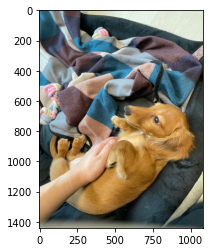

In [2]:
img = Image.open('./bori.jpg')
fig = plt.figure()
plt.imshow(img);

* 원본 이미지인 HxWxC 를 트랜스포머의 인풋에 넣기 위하여 패치 임베딩을 해줘야 한다.

In [3]:
transform = Compose([Resize((224,224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

In [4]:
patch_size = 16 #16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.size()

torch.Size([1, 196, 768])

### PatchEmbedding 
직관적으로 nn.Linear 을 통해 linear combination

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size : int=16, emb_size : int=768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            #이미지를 패치로 나누고 flatten
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size) #linear projection 하려고
        )
        
    def forward(self, x:Tensor) -> Tensor:
        x = self.projection(x)
        return x 
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size : int=16, emb_size : int=768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # linear 대신에 conv layer을 사용하여 성능개선
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
    
    def forward(self,x:Tensor) -> Tensor:
        x = self.projection(x)
        return x 
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

## CLS Token

cls_token is a torch Parameter randomly initialized, in the forward the method it is copied b (batch) times and prepended before the projected patches using torch.cat


In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size :int=16, emb_size : int=768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size = patch_size, stride = patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b,_,_,_ = x.shape
        x = self.proj(x)
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_token, x], dim=1)
        return x 
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

## Positional Embedding

이미지 패치에 대한 spatial information 을 전달하기 위해서 position embedding 이라는 것을 추가하게 된다.

텐서 크기는 패치와 동일하게 (패치의수+1(cls), Emb_size)가 되어야한다.

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

# Transformer Encoder

어텐션을 계산하기 위해 인풋으로 query, key , value가 필요하며 query,key 곱을 통해서 

시퀀스안의 요소들의 영향력을 계산한다. MultiheadAttention을 사용하므로 차원을 맞춰주기 위해 rearrange를 사용하여 

input x의 shape이 [batch, 패치길이+1, 임베딩차원] 였던 것을 [batch, 헤드개수, 패치길이+1, 임베딩/헤드개수] 로 변환

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # 쿼리,키 연산
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        #어텐션 스코어
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

## Residuals

인코더 블럭에는 residual connection이 들어간다

아래와 같이 간단하게 구현가능

In [20]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

## MLP

MHA 이후 진행되는 MLP에 대한 코드이다. Linear, GELU, Dropout, Linear로 구성되어 있으며
임베딩 사이즈의 4배만큼 expansion을 곱해주고 dropout 이후에는 다시 원래 사이즈로 축소한다

In [21]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

## Transformer Encoder Block


위 클래스들을 이용하여 트랜스포머 인코더 클래스를 구현한다. nn.Module대신 nn.Sequential 을 상속받아 forward의 재정의가 필요없다.

In [22]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [23]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

위에서 구현한 TransformerBlock을 이용하여 12개의 블럭을지닌 인코더

In [24]:

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

마지막의 classificationhead

In [25]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

## 최종

In [26]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [28]:
summary(ViT(), (3, 224, 224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1